In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

% matplotlib inline
plt.rcParams['figure.figsize'] = (5.0,4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload

%autoreload 2

np.random.seed(1)

In [2]:
import numpy as np

arr = np.array([[[1, 1, 2, 2, 3, 4],
             [1, 1, 2, 2, 3, 4], 
             [1, 1, 2, 2, 3, 4]], 

            [[0, 1, 2, 3, 4, 5], 
             [0, 1, 2, 3, 4, 5], 
             [0, 1, 2, 3, 4, 5]], 

            [[1, 1, 2, 2, 3, 4], 
             [1, 1, 2, 2, 3, 4], 
             [1, 1, 2, 2, 3, 4]]])
arr

array([[[1, 1, 2, 2, 3, 4],
        [1, 1, 2, 2, 3, 4],
        [1, 1, 2, 2, 3, 4]],

       [[0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5]],

       [[1, 1, 2, 2, 3, 4],
        [1, 1, 2, 2, 3, 4],
        [1, 1, 2, 2, 3, 4]]])

In [3]:
a = np.pad(arr,((0,0),(1,1),(2,2)),'constant')
a

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 2, 2, 3, 4, 0, 0],
        [0, 0, 1, 1, 2, 2, 3, 4, 0, 0],
        [0, 0, 1, 1, 2, 2, 3, 4, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 2, 3, 4, 5, 0, 0],
        [0, 0, 0, 1, 2, 3, 4, 5, 0, 0],
        [0, 0, 0, 1, 2, 3, 4, 5, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 2, 2, 3, 4, 0, 0],
        [0, 0, 1, 1, 2, 2, 3, 4, 0, 0],
        [0, 0, 1, 1, 2, 2, 3, 4, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]])

In [4]:
def zero_pad(X, pad):
    """
   把数据集X的图像边界全部使用0来扩充pad个宽度和高度。

   参数：
       X - 图像数据集，维度为（样本数，图像高度，图像宽度，图像通道数）
       pad - 整数，每个图像在垂直和水平维度上的填充量
   返回：
       X_paded - 扩充后的图像数据集，维度为（样本数，图像高度 + 2*pad，图像宽度 + 2*pad，图像通道数）

   """


    X_pad = np.pad(X,
               ((0, 0),  # 样本数，不填充
                (pad, pad),  # 图像height
                (pad, pad),  # 图像weight
                (0, 0)),  # channels
               'constant', constant_values=0)

    return X_pad

x 的 shape= (4, 3, 3, 2)
x_paded 的 shape= (4, 7, 7, 2)
x[1,1]= [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_paded[1,1]= [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


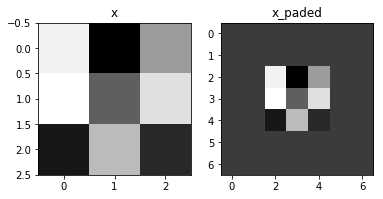

In [5]:
x = np.random.randn(4,3,3,2)
x_paded = zero_pad(x,2)

print('x 的 shape=',x.shape)
print('x_paded 的 shape=',x_paded.shape)
print('x[1,1]=',x[1,1])
print('x_paded[1,1]=',x_paded[1,1])

fig , axarr = plt.subplots(1,2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_paded')
axarr[1].imshow(x_paded[0,:,:,0])

In [6]:
def conv_single_step(a_slice_prev,W,b):
    '''
    在前一层的激活输出的一个片段应用一个由参数W定义的过滤器
    这里切片大小和过滤器大小相同
    
    参数：
        a_slice_prev - 输入数据的一个片段，维度为(过滤器大小，过滤器大小，上一通道数)
        W - 权重参数，包含在一个矩阵中，维度为(过滤器大小，过滤器大小，上一通道数)
        b  - 偏置参数，包含在一个矩阵中，维度为（1，1，1）
        
    返回参数：
        Z -  在输入数据的片上卷积后的结果
    '''
    s = np.multiply(a_slice_prev,W) + b
    Z = np.sum(s)
    
    return Z

In [7]:
np.random.seed(1)

a_slice_prev = np.random.randn(4,4,3)
W = np.random.randn(4,4,3)
b = np.random.randn(1,1,1)

Z = conv_single_step(a_slice_prev,W,b)
Z

-23.16021220252078

In [8]:
def conv_forward(A_prev,W,b,hparameters):
    '''
    实现卷积操作的前向传播
    
    参数：
        A_prev - 上一层的激活输出矩阵，维度为（m,n_H_prev,n_W_prev,n_C_prev）
        W - 权重矩阵，维度为(f,f,n_C_prev,n_C)
        b - 偏置矩阵，维度为(1,1,1,n_C)
        hparameters - 包含了‘stride’和'pad'的超参数字典
    
    返回：
        Z - 卷积输出，维度为(m,n_H,n_W,n_C)
        cache - 缓存了一些反向传播函数conv_backward()需要的一些数据
    '''
    
    (m,n_H_prev,n_W_prev,n_C_prev) = A_prev.shape
    (f,f,n_C_prev,n_C) = W.shape
    
    stride = hparameters['stride']
    pad = hparameters['pad']
    # 卷积计算公式
    n_H = int((n_H_prev + 2 * pad - f) / stride) + 1
    n_W = int((n_W_prev + 2 * pad - f) / stride) + 1
    
    Z = np.zeros((m,n_H,n_W,n_C))
    # padding
    A_prev_pad = zero_pad(A_prev,pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start +f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    Z[i,h,w,c] = conv_single_step(a_slice_prev,W[:,:,:,c],b[:,:,:,c])
                    
    assert(Z.shape == (m,n_H,n_W,n_C))
    
    cache = (A_prev,W,b,hparameters)
    
    return (Z,cache)

In [9]:
np.random.seed(1)

A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)

hparameters = {"pad" : 2, "stride": 1}

Z , cache_conv = conv_forward(A_prev,W,b,hparameters)

print("np.mean(Z) = ", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

np.mean(Z) =  0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [14]:
def pool_forward(A_prev,hparameters,mode='max'):
    '''
    实现池化层的前向传播
    参数：
        A_prev - 输入数据，维度为(m,n_H_prev,n_W_prev,n_C_prev)
        hparameters - 超参数，包括f和stride两个参数的字典
        mode - 模式，max和average两种模式，最大池化和均值池化
    
    返回：
        A - 池化层的输出，维度为(m,n_H,n_W,n_C)
        cache - 存储部分反向传播需要的值，包括输入和超参数的字典
    '''
    (m,n_H_prev,n_W_prev,n_C_prev) = A_prev.shape
    f = hparameters['f']
    stride = hparameters['stride']
    # 维度计算
    n_H = int((n_H_prev - f)/stride)+1
    n_W = int((n_W_prev - f)/stride)+1
    n_C = n_C_prev
    
    A = np.zeros((m,n_H,n_W,n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride         #竖向，开始的位置
                    vert_end = vert_start + f       #竖向，结束的位置
                    horiz_start = w * stride        #横向，开始的位置
                    horiz_end = horiz_start + f     #横向，结束的位置
                    #定位完毕，开始切割
                    a_slice_prev = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    if mode == 'max':
                        A[i,h,w,c] = np.max(a_slice_prev)
                    elif mode == 'mean':
                        A[i,h,w,c] = np.mean(a_slice_prev)
    
    assert(A.shape == (m,n_H,n_W,n_C))
    
    cache = (A_prev,hparameters)
    
    return A,cache

In [15]:
np.random.seed(1)
A_prev = np.random.randn(2,4,4,3)
hparameters = {'f':4,'stride':1}

A,cache = pool_forward(A_prev,hparameters,mode = 'max')
print('mode = max')
print('A=',A)
print('-------------------------')
A,cache = pool_forward(A_prev,hparameters,mode='mean')
print('mode = mean')
print('A=',A)

mode = max
A= [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]
-------------------------
mode = mean
A= [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


In [16]:
def conv_backward(dZ,cache):
    """
    实现卷积层的反向传播

    参数：
        dZ - 卷积层的输出Z的 梯度，维度为(m, n_H, n_W, n_C)
        cache - 反向传播所需要的参数，conv_forward()的输出之一

    返回：
        dA_prev - 卷积层的输入（A_prev）的梯度值，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        dW - 卷积层的权值的梯度，维度为(f,f,n_C_prev,n_C)
        db - 卷积层的偏置的梯度，维度为（1,1,1,n_C）

    """
    #获取cache的值
    (A_prev, W, b, hparameters) = cache

    #获取A_prev的基本信息
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    #获取dZ的基本信息
    (m,n_H,n_W,n_C) = dZ.shape

    #获取权值的基本信息
    (f, f, n_C_prev, n_C) = W.shape

    #获取hparaeters的值
    pad = hparameters["pad"]
    stride = hparameters["stride"]

    #初始化各个梯度的结构
    dA_prev = np.zeros((m,n_H_prev,n_W_prev,n_C_prev))
    dW = np.zeros((f,f,n_C_prev,n_C))
    db = np.zeros((1,1,1,n_C))

    #前向传播中我们使用了pad，反向传播也需要使用，这是为了保证数据结构一致
    A_prev_pad = zero_pad(A_prev,pad)
    dA_prev_pad = zero_pad(dA_prev,pad)

    #现在处理数据
    for i in range(m):
        #选择第i个扩充了的数据的样本,降了一维。
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位切片位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    #定位完毕，开始切片
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    #切片完毕，使用上面的公式计算梯度
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
        #设置第i个样本最终的dA_prev,即把非填充的数据取出来。
        dA_prev[i,:,:,:] = da_prev_pad[pad:-pad, pad:-pad, :]

    #数据处理完毕，验证数据格式是否正确
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return (dA_prev,dW,db)

In [17]:
np.random.seed(1)
#初始化参数
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2, "stride": 1}

#前向传播
Z , cache_conv = conv_forward(A_prev,W,b,hparameters)
#反向传播
dA , dW , db = conv_backward(Z,cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 9.608990675868995
dW_mean = 10.581741275547566
db_mean = 76.37106919563735


In [18]:
def create_mask_from_window(x):
    """
    从输入矩阵中创建掩码，以保存最大值的矩阵的位置。

    参数：
        x - 一个维度为(f,f)的矩阵

    返回：
        mask - 包含x的最大值的位置的矩阵
    """
    mask = x == np.max(x)

    return mask

In [19]:
def distribute_value(dz,shape):
    """
    给定一个值，为按矩阵大小平均分配到每一个矩阵位置中。

    参数：
        dz - 输入的实数
        shape - 元组，两个值，分别为n_H , n_W

    返回：
        a - 已经分配好了值的矩阵，里面的值全部一样。

    """
    #获取矩阵的大小
    (n_H , n_W) = shape

    #计算平均值
    average = dz / (n_H * n_W)

    #填充入矩阵
    a = np.ones(shape) * average

    return a

In [20]:
def pool_backward(dA,cache,mode = "max"):
    """
    实现池化层的反向传播

    参数:
        dA - 池化层的输出的梯度，和池化层的输出的维度一样
        cache - 池化层前向传播时所存储的参数。
        mode - 模式选择，【"max" | "average"】

    返回：
        dA_prev - 池化层的输入的梯度，和A_prev的维度相同

    """
    #获取cache中的值
    (A_prev , hparaeters) = cache

    #获取hparaeters的值
    f = hparaeters["f"]
    stride = hparaeters["stride"]

    #获取A_prev和dA的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape
    (m , n_H , n_W , n_C) = dA.shape

    #初始化输出的结构
    dA_prev = np.zeros_like(A_prev)

    #开始处理数据
    for i in range(m):
        a_prev = A_prev[i]      
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位切片位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    #选择反向传播的计算方式
                    if mode == "max":
                        #开始切片
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        #创建掩码
                        mask = create_mask_from_window(a_prev_slice)
                        #计算dA_prev
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c] += np.multiply(mask,dA[i,h,w,c])

                    elif mode == "average":
                        #获取dA的值
                        da = dA[i,h,w,c]
                        #定义过滤器大小
                        shape = (f,f)
                        #平均分配
                        dA_prev[i,vert_start:vert_end, horiz_start:horiz_end ,c] += distribute_value(da,shape)
    #数据处理完毕，开始验证格式
    assert(dA_prev.shape == A_prev.shape)

    return dA_prev

## tensorflow模型

In [22]:
import math
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.framework import ops

import cnn_utils

%matplotlib inline
np.random.seed(1)

In [24]:
X_train_orig,Y_train_orig,X_test_orig,Y_test_orig,classes = cnn_utils.load_dataset()

y=2


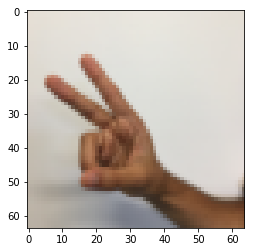

In [25]:
index = 6
plt.imshow(X_train_orig[index])
print('y='+str(np.squeeze(Y_train_orig[:,index])))

In [26]:
X_train = X_train_orig/255
X_test = X_test_orig / 255
Y_train = cnn_utils.convert_to_one_hot(Y_train_orig,6).T
Y_test = cnn_utils.convert_to_one_hot(Y_test_orig,6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [27]:
def create_placeholder(n_H0,n_W0,n_C0,n_y):
    '''
    为session创建占位符
    参数：
        n_H0-实数，输入图像的高度
        n_W0-实数，输入图像的宽度
        n_C0-实数，输入图像的通道
        n_y-实数，分类数
        
    输出：
        X - 输入数据的占位符，维度为[None, n_H0, n_W0, n_C0]，类型为"float"
        Y - 输入数据的标签的占位符，维度为[None, n_y]，维度为"float"
    '''
    
    X = tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0])
    Y = tf.placeholder(tf.float32,[None,n_y])
    
    return X,Y

In [28]:
X,Y = create_placeholder(64,64,3,6)
print('X=',str(X))
print('Y=',str(Y))

X= Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y= Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [29]:
def initialize_parameters():
    '''
    初始化权重矩阵，硬编码为
    W1:[4,4,3,8]
    W2:[2,2,8,16]
    
    返回：
        包含tensor类型的W1，W2的字典
    '''
    tf.set_random_seed(1)
    
    W1 = tf.get_variable('W1',[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable('W2',[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))    
    
    parameters = {
        'W1':W1,
        'W2':W2
    }
    return parameters

In [31]:
tf.reset_default_graph()

with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print('W1='+str(parameters['W1'].eval()[1,1,1]))
    print('W2='+str(parameters['W2'].eval()[1,1,1]))
    
    sess_test.close()

W1=[ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2=[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [34]:
def forward_propagation(X,parameters):
    '''
    实现前向传播
    CONV2D->RELU->MAXPOOL->CONV2D->RELU->MAXPOOL->FLATTEN->FULLYCONNECTED
    
    参数：
        X - 输入数据的placeholder,维度为(输入节点数量，样本数量)
        parameter - 包括W1和W2的字典
        
    返回：
        Z3 - 最后一个节点的输出
    '''
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    #Conv2d ,stride = 1 pad = same
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    # ReLU
    A1 = tf.nn.relu(Z1)
    #Maxpool ,f = 8*8,stride = 8*8,pad = same
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    
    #Conv2d,stride = 1,pad = same
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    #ReLU
    A2 = tf.nn.relu(Z2)
    #Maxpool ,f = 4*4,stride = 4*4,pad = same
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    
    # Flatten
    P = tf.contrib.layers.flatten(P2)
    #全连接层
    Z3 = tf.contrib.layers.fully_connected(P,6,activation_fn=None)
    
    return Z3

In [35]:
tf.reset_default_graph()
np.random.seed(1)
with tf.Session() as sess:
    X,Y = create_placeholder(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    a = sess.run(Z3,{X:np.random.randn(2,64,64,3),Y:np.random.randn(2,6)})
    print('Z3 = '+str(a))
    
    sess.close()

Z3 = [[-0.44670227 -1.5720876  -1.5304923  -2.3101304  -1.2910438   0.46852064]
 [-0.17601591 -1.5797201  -1.4737016  -2.616721   -1.0081065   0.5747785 ]]


In [38]:
def computer_cost(Z3,Y):
    '''
    计算成本
    参数：
        Z3 - 正向传播最后一个节点的输出，维度为（6，样本数）
        Y - 标签向量的placeholder，和Z3的维度相同
    '''
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    
    return cost

In [39]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X,Y = create_placeholder(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = computer_cost(Z3,Y)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost,{X:np.random.randn(4,64,64,3),Y:np.random.randn(4,6)})
    print('cost='+str(a))
    sess.close()

cost=2.9103398


In [44]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.005,
                num_epochs = 100,minibatch_size=64,print_cost=True,isPlot=True):
    '''
    使用Tensorflow实现三层的神经网络
    CONV2D->RELU->MAXPOOL->CONV2D->RELU->MAXPOOL->FLATTEN->FULLYCONNECTED
    参数：
        X_train - 训练数据，维度为(None, 64, 64, 3)
        Y_train - 训练数据对应的标签，维度为(None, n_y = 6)
        X_test - 测试数据，维度为(None, 64, 64, 3)
        Y_test - 训练数据对应的标签，维度为(None, n_y = 6)
        learning_rate - 学习率
        num_epochs - 遍历整个数据集的次数
        minibatch_size - 每个小批量数据块的大小
        print_cost - 是否打印成本值，每遍历100次整个数据集打印一次
        isPlot - 是否绘制图谱
    返回：
        train_accuracy - 实数，训练集的准确度
        test_accuracy - 实数，测试集的准确度
        parameters - 学习后的参数
    '''
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m,n_H0,n_W0,n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X,Y = create_placeholder(n_H0,n_W0,n_C0,n_y)
    # 初始化参数
    parameters = initialize_parameters()
    # 前向传播
    Z3 = forward_propagation(X,parameters)
    #计算成本
    cost = computer_cost(Z3,Y)
    #反向传播
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    #全局初始化所有变量
    init = tf.global_variables_initializer()
    #
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = cnn_utils.random_mini_batches(X_train,Y_train,minibatch_size,seed)
            
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y) = minibatch
                _,temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_epochs
            if print_cost:
                if epoch % 5 == 0:
                    print('当前是第'+str(epoch)+'代，成本值为：'+str(minibatch_cost))
                    
            if epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        if isPlot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations(per tens)')
            plt.title('Learning rate='+str(learning_rate))
            plt.show()
        
        # 开始预测
        predict_op = tf.arg_max(Z3,1)  # tf.arg_max() :取行或者列的最大值的位置。
        corrent_prediction = tf.equal(predict_op,tf.arg_max(Y,1))
        
        # 计算准确度
        accuracy = tf.reduce_mean(tf.cast(corrent_prediction,'float'))
        print('corrent_prediction accuracy = ' + str(accuracy))
        
        train_accuracy = accuracy.eval({X:X_train,Y:Y_train})       
        test_accuracy = accuracy.eval({X:X_test,Y:Y_test})
        
        print("训练集准确度：" + str(train_accuracy))
        print("测试集准确度：" + str(test_accurary))
        
        return (train_accuracy,test_accuracy,parameters)

当前是第0代，成本值为：0.204287478129069
当前是第5代，成本值为：0.18356425046920777
当前是第10代，成本值为：0.10849233547846478
当前是第15代，成本值为：0.07648267765839893
当前是第20代，成本值为：0.05862237552801769
当前是第25代，成本值为：0.04888913313547771
当前是第30代，成本值为：0.039715272585550944
当前是第35代，成本值为：0.03454324245452881
当前是第40代，成本值为：0.02795598606268565
当前是第45代，成本值为：0.02412424832582474
当前是第50代，成本值为：0.02092383603254954
当前是第55代，成本值为：0.019158472766478855
当前是第60代，成本值为：0.016197856763998666
当前是第65代，成本值为：0.01677998279531797
当前是第70代，成本值为：0.01361674301326275
当前是第75代，成本值为：0.012278332486748696
当前是第80代，成本值为：0.011325787728031476
当前是第85代，成本值为：0.008562845264871914
当前是第90代，成本值为：0.008892370114723842
当前是第95代，成本值为：0.010610184172789257
当前是第100代，成本值为：0.0055779611691832535
当前是第105代，成本值为：0.005227272721628348
当前是第110代，成本值为：0.004302012889335553
当前是第115代，成本值为：0.003357940092682838
当前是第120代，成本值为：0.004967502417663735
当前是第125代，成本值为：0.0024333898350596427
当前是第130代，成本值为：0.0021900045995910966
当前是第135代，成本值为：0.002613991821805636
当前是第140代，成本值为：0.001729132489611705
当前是第145代，成本值为：0.00

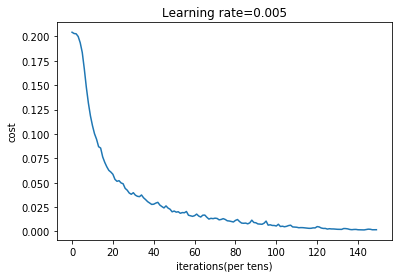

Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
corrent_prediction accuracy = Tensor("Mean_1:0", shape=(), dtype=float32)
训练集准确度：1.0


NameError: name 'test_accuary' is not defined

In [43]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=150)